___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2025

___
### Import libraries and sub-libraries.

In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from tqdm.notebook import tqdm
import datetime
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [2]:
# from fontsetting import font_cmu
# plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

Device available: cuda


___
### Read training data from `data/train/hig-res` and `data/train/low-res`


In [4]:
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, transform=None, augment=False, dataset_name="Dataset"):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.transform = transform
        self.augment = augment
        self.dataset_name = dataset_name
        self.original_filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
        self.num_original_images = len(self.original_filenames)

        self.low_res_images = []
        self.high_res_images = []

        for filename in self.original_filenames:
            high_res_path = os.path.join(self.high_res_dir, filename)
            low_res_path = os.path.join(self.low_res_dir, filename)

            # Load original images
            try:
                hr_img = Image.open(high_res_path)
                lr_img = Image.open(low_res_path)
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
                continue

            # Resize low-res to 128x128
            lr_img = lr_img.resize((128, 128), Image.BICUBIC)

            original_lr, original_hr = lr_img, hr_img
            processed_lr = []
            processed_hr = []

            if self.augment:
                # --- Apply transformations ---
                # 1) Original
                processed_lr.append(original_lr)
                processed_hr.append(original_hr)
                # 2) Rotated by 90 degrees
                processed_lr.append(original_lr.rotate(90))
                processed_hr.append(original_hr.rotate(90))
                # 3) Rotated by 180 degrees
                processed_lr.append(original_lr.rotate(180))
                processed_hr.append(original_hr.rotate(180))
                # 4) Rotated by 270 degrees
                processed_lr.append(original_lr.rotate(270))
                processed_hr.append(original_hr.rotate(270))

                # Apply flips
                lr_v_flip = original_lr.transpose(Image.FLIP_LEFT_RIGHT)
                hr_v_flip = original_hr.transpose(Image.FLIP_LEFT_RIGHT)
                lr_h_flip = original_lr.transpose(Image.FLIP_TOP_BOTTOM)
                hr_h_flip = original_hr.transpose(Image.FLIP_TOP_BOTTOM)

                # 5) Mirrored on the vertical axis (Flip Left/Right)
                processed_lr.append(lr_v_flip)
                processed_hr.append(hr_v_flip)
                # 6) Mirrored on the horizontal axis (Flip Top/Bottom)
                processed_lr.append(lr_h_flip)
                processed_hr.append(hr_h_flip)

                # Apply flips combined with rotation (unique combinations)
                # 7) Rotated by 90 degrees and mirrored on the vertical axis
                processed_lr.append(lr_v_flip.rotate(90))
                processed_hr.append(hr_v_flip.rotate(90))
                # 8) Rotated by 90 degrees and mirrored on the horizontal axis
                processed_lr.append(lr_h_flip.rotate(90))
                processed_hr.append(hr_h_flip.rotate(90))
            else:
                # If not augmenting, just use the original
                processed_lr.append(original_lr)
                processed_hr.append(original_hr)

            # Apply the final transform (ToTensor) and store
            if self.transform:
                for lr, hr in zip(processed_lr, processed_hr):
                    self.low_res_images.append(torch.clamp(self.transform(lr), min=0.0, max=1.0))
                    self.high_res_images.append(torch.clamp(self.transform(hr), min=0.0, max=1.0))
            else:
                 # If no transform, store PIL images (not recommended for training/eval)
                self.low_res_images.extend(processed_lr)
                self.high_res_images.extend(processed_hr)

    # Get the number of samples in the dataset (original or augmented)
    def __len__(self):
        return len(self.low_res_images)

    # Get the sample at the given index
    def __getitem__(self, idx):
        # Return pre-processed tensors
        return self.low_res_images[idx], self.high_res_images[idx]
    
    def verify_clamped_values(self):
        """
        Verifies the min/max values of the loaded and clamped tensors.
        """
        print(f"\n--- Verifying Clamped Values for {self.dataset_name} ---")
        if not self.low_res_images or not self.high_res_images:
            print("No images loaded to verify.")
            return

        min_lr, max_lr = float('inf'), float('-inf')
        min_hr, max_hr = float('inf'), float('-inf')

        # Check low-resolution images
        for tensor in self.low_res_images:
            current_min_lr = torch.min(tensor).item()
            current_max_lr = torch.max(tensor).item()
            if current_min_lr < min_lr: min_lr = current_min_lr
            if current_max_lr > max_lr: max_lr = current_max_lr

        # Check high-resolution images
        for tensor in self.high_res_images:
            current_min_hr = torch.min(tensor).item()
            current_max_hr = torch.max(tensor).item()
            if current_min_hr < min_hr: min_hr = current_min_hr
            if current_max_hr > max_hr: max_hr = current_max_hr

        print(f"Low-Res Images (Clamped): Min={min_lr:.8f}, Max={max_lr:.8f}")
        print(f"High-Res Images (Clamped): Min={min_hr:.8f}, Max={max_hr:.8f}")
        print("----------------------------------------------")

# Define a transform to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Function to create data loader
def create_loader(dataset, batch_size, shuffle_data=True): # Added shuffle parameter
    torch.manual_seed(0)  # For reproducibility
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_data)

### Create a custom loss class to easily implement custom loss functions.

In [5]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, device='cpu', stage_weights=None):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha # Weight for MSE (PSNR) loss component
        self.beta = beta # Weight for SSIM loss component
        self.mse = nn.MSELoss()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
        self.device = device
        # Weights for intermediate outputs (e.g., [0.2, 0.3, 0.5] for 3 stages)
        self.stage_weights = stage_weights if stage_weights else [1.0] # Default: only use final output

    def forward(self, y_preds, y_true):
        # y_preds can be a single tensor (SRNet) or a list/tuple (MPRNet: final_out, intermediate_list)
        # y_true is always the single ground truth tensor

        y_true = y_true.to(self.device)
        total_loss = 0.0

        # Check if y_preds is the tuple from MPRNet
        if isinstance(y_preds, (list, tuple)) and len(y_preds) == 2 and isinstance(y_preds[1], list):
            intermediate_outputs = y_preds[1] # The list [stage1_img, stage2_img, final_out]
            num_outputs = len(intermediate_outputs)

            if len(self.stage_weights) != num_outputs:
                fallback_weight = 1.0 / num_outputs
                self.stage_weights = [fallback_weight] * num_outputs
                # Keep print statement for debugging if needed, but remove for final version
                # print(f"Warning: Mismatched stage_weights ({len(self.stage_weights)}) and MPRNet intermediate outputs ({num_outputs}). Using equal weights: {self.stage_weights}")

            # --- Optional Debug Block ---
            # print("\n--- Loss Components (MPRNet Stages) ---")
            # stage_losses_debug = []
            # --- End Debug Block ---
            for i, y_pred_stage in enumerate(intermediate_outputs):
                y_pred_stage = y_pred_stage.to(self.device)
                mse_loss_stage = self.mse(y_pred_stage, y_true)
                # Clamp predicted image before SSIM calculation
                y_pred_stage_clamped = torch.clamp(y_pred_stage, 0.0, 1.0)
                ssim_val_stage = self.ssim(y_pred_stage_clamped, y_true)
                # Clamp the calculated SSIM value itself to prevent issues
                ssim_val_stage_clamped = torch.clamp(ssim_val_stage, min=-1.0, max=1.0) # Clamp between theoretical bounds
                ssim_loss_stage = 1.0 - ssim_val_stage_clamped # Use clamped value for loss
                stage_loss = (self.alpha * mse_loss_stage) + (self.beta * ssim_loss_stage)
                # --- Optional Debug Block ---
                # print(f"  Stage {i}: MSE={mse_loss_stage.item():.4f}, SSIM_val={ssim_val_stage.item():.4f}, SSIM_loss={ssim_loss_stage.item():.4f}, WeightedStageLoss={self.stage_weights[i] * stage_loss.item():.4f}")
                # stage_losses_debug.append(self.stage_weights[i] * stage_loss.item())
                # --- End Debug Block ---
                total_loss += self.stage_weights[i] * stage_loss
            # --- Optional Debug Block ---
            # print(f"  Sum of Weighted Stage Losses: {sum(stage_losses_debug):.4f}, Final Total Loss: {total_loss.item():.4f}")
            # print("--------------------------------------")
            # --- End Debug Block ---

        else: # SRNet case (or if MPRNet output format changes unexpectedly)
            y_pred = y_preds[0] if isinstance(y_preds, (list, tuple)) else y_preds
            y_pred = y_pred.to(self.device)
            mse_loss = self.mse(y_pred, y_true)
            # Clamp predicted image before SSIM calculation
            y_pred_clamped = torch.clamp(y_pred, 0.0, 1.0)
            ssim_val = self.ssim(y_pred_clamped, y_true)
            # Clamp the calculated SSIM value itself to prevent issues
            ssim_val_clamped = torch.clamp(ssim_val, min=-1.0, max=1.0) # Clamp between theoretical bounds
            ssim_loss = 1.0 - ssim_val_clamped # Use clamped value for loss
            total_loss = (self.alpha * mse_loss) + (self.beta * ssim_loss)
            # --- Optional Debug Block ---
            # print(f"\n--- Loss Components (SRNet/Fallback) ---\nMSE={mse_loss.item():.4f}, SSIM_val={ssim_val.item():.4f}, SSIM_loss={ssim_loss.item():.4f}, Final Total Loss: {total_loss.item():.4f}\n--------------------------------------")
            # --- End Debug Block ---

        # Add a check just before returning (optional, can be removed after confirming fix)
        # if total_loss.item() < 0:
        #     print(f"ALERT: Negative total loss detected: {total_loss.item()} !!!")

        return total_loss

___
### Define a super-resolution network

#### Here, I have defined a trivial network, which has only two layers and no activation function. We are essentially doing linear filtering.

In [6]:
class SRNet(nn.Module):
    def __init__(self):
        super(SRNet, self).__init__()

        self.relu = nn.ReLU(inplace=True)
        upscale_factor = 2
        channels_mult = upscale_factor * upscale_factor # = 4

        # --- Initial Feature Extraction ---
        # Input: 1 x 128 x 128
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=80, kernel_size=3, padding=1) # 80 x 128 x 128
        self.conv1b = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80 x 128 x 128

        # --- Upscaling Path 1 (128 -> 256) using PixelShuffle ---
        # Main Path
        self.upscale1_conv = nn.Conv2d(in_channels=80, out_channels=80 * channels_mult, kernel_size=3, padding=1) # 80*4 x 128 x 128
        self.pixel_shuffle1 = nn.PixelShuffle(upscale_factor) # -> 80 x 256 x 256
        self.conv2 = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80 x 256 x 256
        self.conv2b = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80 x 256 x 256
        # Skip Path 1 (Interpolate features from 128x128 stage)
        self.bskip1 = nn.Upsample(scale_factor=upscale_factor, mode='bicubic', align_corners=False) # Interpolates 80 channels to 256x256
        # Convolution after combining skip connection 1 (Input channels = 80 from main path + 80 from skip = 160)
        self.conv_after_skip1 = nn.Conv2d(in_channels=160, out_channels=80, kernel_size=3, padding=1) # 160x256x256 -> 80x256x256
        self.conv_after_skip1b = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80x256x256

        # --- Upscaling Path 2 (256 -> 512) using PixelShuffle & Widened Middle ---
        # Main Path
        self.upscale2_conv = nn.Conv2d(in_channels=80, out_channels=80 * channels_mult, kernel_size=3, padding=1) # 80*4 x 256 x 256 (Widened)
        self.pixel_shuffle2 = nn.PixelShuffle(upscale_factor) # -> 80 x 512 x 512 (Widened)
        self.conv3 = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80 x 512 x 512 (Widened)
        self.conv3b = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80 x 512 x 512 (Widened)
        # Skip Path 2 (Interpolate features from 256x256 stage after conv_after_skip1b)
        self.bskip2 = nn.Upsample(scale_factor=upscale_factor, mode='bicubic', align_corners=False) # Interpolates 80 channels to 512x512
        # Convolution after combining skip connection 2 (Input channels = 80 from main path + 80 from skip = 160) (Widened)
        self.conv_after_skip2 = nn.Conv2d(in_channels=160, out_channels=80, kernel_size=3, padding=1) # 160x512x512 -> 80x512x512 (Widened)
        self.conv_after_skip2b = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80x512x512 (Widened)

        # --- Downscaling Path (512 -> 256) ---
        # Input channel matches the widened middle stage (80)
        self.downscale = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=2, stride=2) # 80x512x512 -> 80x256x256
        self.conv4 = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80x256x256
        self.conv4b = nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1) # 80x256x256

        # --- Final Output Layer ---
        # Takes the output of the downscaling path (80 channels) and maps to 1 channel
        self.conv_out_final = nn.Conv2d(in_channels=80, out_channels=1, kernel_size=3, padding=1) # 80x256x256 -> 1x256x256

    def forward(self, x):
        # x: Input 1 x 128 x 128

        # --- Initial Feature Extraction ---
        features128 = self.relu(self.conv1(x))
        features128 = self.relu(self.conv1b(features128)) # 80 x 128 x 128

        # --- Upscaling Path 1 + Skip Connection 1 ---
        # Calculate interpolated skip features first
        skip1_interpolated = self.bskip1(features128) # 80 x 256 x 256
        # Main path upscale using PixelShuffle
        up1_conv_out = self.upscale1_conv(features128) # 80*4 x 128 x 128
        up1_out = self.pixel_shuffle1(up1_conv_out)    # 80 x 256 x 256
        features256_main = self.relu(self.conv2(up1_out))
        features256_main = self.relu(self.conv2b(features256_main)) # 80 x 256 x 256
        # Concatenate main path features and interpolated skip features
        concat1 = torch.cat((features256_main, skip1_interpolated), dim=1) # 160 x 256 x 256
        # Process combined features
        features256_processed = self.relu(self.conv_after_skip1(concat1))
        features256_processed = self.relu(self.conv_after_skip1b(features256_processed)) # 80 x 256 x 256

        # --- Upscaling Path 2 + Skip Connection 2 ---
        # Calculate interpolated skip features (using output from conv_after_skip1b)
        skip2_interpolated = self.bskip2(features256_processed) # 80 x 512 x 512
        # Main path upscale using PixelShuffle (Widened Middle)
        up2_conv_out = self.upscale2_conv(features256_processed) # 80*4 x 256 x 256
        up2_out = self.pixel_shuffle2(up2_conv_out)    # 80 x 512 x 512
        features512_main = self.relu(self.conv3(up2_out))
        features512_main = self.relu(self.conv3b(features512_main)) # 80 x 512 x 512
        # Concatenate main path features and interpolated skip features
        concat2 = torch.cat((features512_main, skip2_interpolated), dim=1) # 160 x 512 x 512
        # Process combined features
        features512_processed = self.relu(self.conv_after_skip2(concat2))
        features512_processed = self.relu(self.conv_after_skip2b(features512_processed)) # 80 x 512 x 512

        # --- Downscaling Path ---
        down_out = self.downscale(features512_processed) # 80 x 256 x 256
        features256_final = self.relu(self.conv4(down_out))
        features256_final = self.relu(self.conv4b(features256_final)) # 80 x 256 x 256

        # --- Final Output Layer ---
        output = self.conv_out_final(features256_final) # 1 x 256 x 256

        return output

In [7]:
# --- Channel Attention Layer (CALayer) ---
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=False),
                nn.PReLU(),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=False),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

# --- Channel Attention Block (CAB) ---
class CAB(nn.Module):
    def __init__(self, n_feat, kernel_size=3, reduction=16, bias=False, act=nn.PReLU()):
        super(CAB, self).__init__()
        modules_body = []
        modules_body.append(nn.Conv2d(n_feat, n_feat, kernel_size, padding=(kernel_size//2), bias=bias))
        modules_body.append(act)
        modules_body.append(nn.Conv2d(n_feat, n_feat, kernel_size, padding=(kernel_size//2), bias=bias))

        self.CA = CALayer(n_feat, reduction)
        self.body = nn.Sequential(*modules_body)
        self.act = act

    def forward(self, x):
        res = self.body(x)
        res = self.CA(res)
        res += x
        return res
    
# Helper Modules ---
def conv(in_channels, out_channels, kernel_size, bias=False, stride = 1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias, stride = stride)

class DownSample(nn.Module):
    def __init__(self, in_channels, s_factor):
        super(DownSample, self).__init__()
        self.down = nn.Sequential(nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False),
                                  nn.Conv2d(in_channels, in_channels + s_factor, 1, stride=1, padding=0, bias=False))

    def forward(self, x):
        return self.down(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, s_factor):
        super(UpSample, self).__init__()
        # Note: Example reduces channels from in_channels+s_factor to in_channels
        # Assuming input 'in_channels' already includes s_factor here based on common U-Net structure
        self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                                nn.Conv2d(in_channels, in_channels - s_factor, 1, stride=1, padding=0, bias=False))

    def forward(self, x):
        return self.up(x)

class SkipUpSample(nn.Module):
    def __init__(self, in_channels, s_factor):
        super(SkipUpSample, self).__init__()
        # Upsamples and reduces channels from in_channels to in_channels - s_factor
        self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                                nn.Conv2d(in_channels, in_channels - s_factor, 1, stride=1, padding=0, bias=False))

    def forward(self, x, y):
        x = self.up(x)
        # y comes from skip connection (already processed by CAB/skip_attn)
        # Ensure channel dimensions match before adding if necessary (should match by design)
        return x + y

# --- Encoder ---
class Encoder(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, act, bias, scale_unetfeats, csff=False):
        super(Encoder, self).__init__()
        num_cab_per_level = 2 # As per denoising example

        self.encoder_level1 = nn.Sequential(*[CAB(n_feat,                     kernel_size, reduction, bias=bias, act=act) for _ in range(num_cab_per_level)])
        self.encoder_level2 = nn.Sequential(*[CAB(n_feat+scale_unetfeats,     kernel_size, reduction, bias=bias, act=act) for _ in range(num_cab_per_level)])
        self.encoder_level3 = nn.Sequential(*[CAB(n_feat+(scale_unetfeats*2), kernel_size, reduction, bias=bias, act=act) for _ in range(num_cab_per_level)])

        self.down12 = DownSample(n_feat, scale_unetfeats)
        self.down23 = DownSample(n_feat+scale_unetfeats, scale_unetfeats)

        # Cross Stage Feature Fusion (CSFF)
        self.csff = csff
        if self.csff:
            self.csff_enc1 = nn.Conv2d(n_feat,                     n_feat,                     kernel_size=1, bias=bias)
            self.csff_enc2 = nn.Conv2d(n_feat+scale_unetfeats,     n_feat+scale_unetfeats,     kernel_size=1, bias=bias)
            self.csff_enc3 = nn.Conv2d(n_feat+(scale_unetfeats*2), n_feat+(scale_unetfeats*2), kernel_size=1, bias=bias)

            self.csff_dec1 = nn.Conv2d(n_feat,                     n_feat,                     kernel_size=1, bias=bias)
            self.csff_dec2 = nn.Conv2d(n_feat+scale_unetfeats,     n_feat+scale_unetfeats,     kernel_size=1, bias=bias)
            self.csff_dec3 = nn.Conv2d(n_feat+(scale_unetfeats*2), n_feat+(scale_unetfeats*2), kernel_size=1, bias=bias)

    def forward(self, x, encoder_outs=None, decoder_outs=None):
        # Level 1
        enc1 = self.encoder_level1(x)
        if self.csff and encoder_outs is not None and decoder_outs is not None:
            enc1 = enc1 + self.csff_enc1(encoder_outs[0]) + self.csff_dec1(decoder_outs[0])

        # Level 2
        x_down12 = self.down12(enc1)
        enc2 = self.encoder_level2(x_down12)
        if self.csff and encoder_outs is not None and decoder_outs is not None:
            enc2 = enc2 + self.csff_enc2(encoder_outs[1]) + self.csff_dec2(decoder_outs[1])

        # Level 3
        x_down23 = self.down23(enc2)
        enc3 = self.encoder_level3(x_down23)
        if self.csff and encoder_outs is not None and decoder_outs is not None:
            enc3 = enc3 + self.csff_enc3(encoder_outs[2]) + self.csff_dec3(decoder_outs[2])

        return [enc1, enc2, enc3] # Return list of features from each level

# --- Decoder ---
class Decoder(nn.Module):
    def __init__(self, n_feat, kernel_size, reduction, act, bias, scale_unetfeats):
        super(Decoder, self).__init__()
        num_cab_per_level = 2 # As per denoising example

        # Feature channels increase with depth in encoder, decrease in decoder
        self.decoder_level1 = nn.Sequential(*[CAB(n_feat,                     kernel_size, reduction, bias=bias, act=act) for _ in range(num_cab_per_level)])
        self.decoder_level2 = nn.Sequential(*[CAB(n_feat+scale_unetfeats,     kernel_size, reduction, bias=bias, act=act) for _ in range(num_cab_per_level)])
        self.decoder_level3 = nn.Sequential(*[CAB(n_feat+(scale_unetfeats*2), kernel_size, reduction, bias=bias, act=act) for _ in range(num_cab_per_level)])

        # Skip connection attention modules
        self.skip_attn1 = CAB(n_feat,                 kernel_size, reduction, bias=bias, act=act)
        self.skip_attn2 = CAB(n_feat+scale_unetfeats, kernel_size, reduction, bias=bias, act=act)

        # Upsampling and skip connection modules
        self.up32 = SkipUpSample(n_feat + (scale_unetfeats*2), scale_unetfeats) # Input from dec3, scales channels down by s_factor
        self.up21 = SkipUpSample(n_feat + scale_unetfeats,     scale_unetfeats) # Input from dec2, scales channels down by s_factor

    def forward(self, outs):
        enc1, enc2, enc3 = outs # Unpack encoder features

        # Level 3 processing
        dec3 = self.decoder_level3(enc3)

        # Level 2 processing
        skip2_processed = self.skip_attn2(enc2)      # Process skip connection
        x_up32 = self.up32(dec3, skip2_processed)    # Upsample, adjust channels, add skip
        dec2 = self.decoder_level2(x_up32)

        # Level 1 processing
        skip1_processed = self.skip_attn1(enc1)      # Process skip connection
        x_up21 = self.up21(dec2, skip1_processed)    # Upsample, adjust channels, add skip
        dec1 = self.decoder_level1(x_up21)

        # Return list of features from each level [Level1, Level2, Level3]
        return [dec1, dec2, dec3]

# --- Original Resolution Block (ORB) ---
class ORB(nn.Module):
    def __init__(self, n_feat, kernel_size=3, reduction=16, act=nn.PReLU(), bias=True, num_cab=8):
        super(ORB, self).__init__()
        modules_body = []
        for _ in range(num_cab):
            modules_body.append(CAB(n_feat, kernel_size, reduction, bias=bias, act=act))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

# --- Original Resolution Subnetwork (ORSNet) ---
class ORSNet(nn.Module):
    def __init__(self, n_feat, scale_orsnetfeats, kernel_size, reduction, act, bias, scale_unetfeats, num_cab):
        super(ORSNet, self).__init__()
        orb_feat_count = n_feat + scale_orsnetfeats # Channels for ORBs

        self.orb1 = ORB(orb_feat_count, kernel_size, reduction, act, bias, num_cab)
        self.orb2 = ORB(orb_feat_count, kernel_size, reduction, act, bias, num_cab)
        self.orb3 = ORB(orb_feat_count, kernel_size, reduction, act, bias, num_cab)

        # Upsamplers for features from Stage 2 Encoder/Decoder paths
        self.up_enc1 = UpSample(n_feat + scale_unetfeats, scale_unetfeats) # H/2->H, n_feat+scale -> n_feat
        self.up_dec1 = UpSample(n_feat + scale_unetfeats, scale_unetfeats) # H/2->H, n_feat+scale -> n_feat

        self.up_enc2 = nn.Sequential(
            UpSample(n_feat + 2*scale_unetfeats, scale_unetfeats), # H/4->H/2, n_feat+2*scale -> n_feat+1*scale
            UpSample(n_feat + scale_unetfeats, scale_unetfeats)    # H/2->H,   n_feat+1*scale -> n_feat
        )
        self.up_dec2 = nn.Sequential(
            UpSample(n_feat + 2*scale_unetfeats, scale_unetfeats), # H/4->H/2, n_feat+2*scale -> n_feat+1*scale
            UpSample(n_feat + scale_unetfeats, scale_unetfeats)    # H/2->H,   n_feat+1*scale -> n_feat
        )

        # 1x1 Convs for fusing features into ORB path
        self.conv_enc1 = nn.Conv2d(n_feat, orb_feat_count, kernel_size=1, bias=bias)
        self.conv_enc2 = nn.Conv2d(n_feat, orb_feat_count, kernel_size=1, bias=bias) # Applied after up_enc1
        self.conv_enc3 = nn.Conv2d(n_feat, orb_feat_count, kernel_size=1, bias=bias) # Applied after up_enc2

        self.conv_dec1 = nn.Conv2d(n_feat, orb_feat_count, kernel_size=1, bias=bias)
        self.conv_dec2 = nn.Conv2d(n_feat, orb_feat_count, kernel_size=1, bias=bias) # Applied after up_dec1
        self.conv_dec3 = nn.Conv2d(n_feat, orb_feat_count, kernel_size=1, bias=bias) # Applied after up_dec2

    def forward(self, x, encoder_outs, decoder_outs):
        # x: input features (n_feat + scale_orsnetfeats channels)
        # encoder_outs: [enc1, enc2, enc3] from Stage 2 Encoder
        # decoder_outs: [dec1, dec2, dec3] from Stage 2 Decoder

        # ORB 1 + Level 0 Fusion (Original Resolution features from Stage 2)
        x = self.orb1(x)
        x = x + self.conv_enc1(encoder_outs[0]) + self.conv_dec1(decoder_outs[0])

        # ORB 2 + Level 1 Fusion (Upsampled from H/2 x W/2 features)
        x = self.orb2(x)
        enc1_upsampled = self.up_enc1(encoder_outs[1])
        dec1_upsampled = self.up_dec1(decoder_outs[1])
        x = x + self.conv_enc2(enc1_upsampled) + self.conv_dec2(dec1_upsampled)

        # ORB 3 + Level 2 Fusion (Upsampled from H/4 x W/4 features)
        x = self.orb3(x)
        enc2_upsampled = self.up_enc2(encoder_outs[2])
        dec2_upsampled = self.up_dec2(decoder_outs[2])
        x = x + self.conv_enc3(enc2_upsampled) + self.conv_dec3(dec2_upsampled)

        return x

# --- Supervised Attention Module (SAM) ---
class SAM(nn.Module):
    def __init__(self, n_feat, kernel_size=3, bias=True):
        super(SAM,self).__init__()
        self.conv1 = nn.Conv2d(n_feat, n_feat, kernel_size, padding=(kernel_size//2), bias=bias)
        self.conv2 = nn.Conv2d(n_feat, 1, kernel_size, padding=(kernel_size//2), bias=bias) # Output residual image
        self.conv3 = nn.Conv2d(1, n_feat, kernel_size, padding=(kernel_size//2), bias=bias) # Process residual for attention map
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, x_img):
        # x: features from previous stage decoder/ORSNet
        # x_img: input image to the current stage (potentially degraded)
        x1 = self.conv1(x)
        # Generate intermediate restored image (residual prediction)
        img = self.conv2(x) + x_img # Add residual to the input image
        # Generate attention map from the intermediate restored image
        attention_map = self.sigmoid(self.conv3(img))
        # Apply attention to features and add skip connection
        x_out = x1 * attention_map + x1 # Use x1 for skip connection as well
        return x_out, img # Return attention-enhanced features and intermediate image

# --- Cross-Stage Feature Fusion (CSFF - Placeholder, implemented within Stage 2) ---
# CSFF involves 1x1 convolutions applied to Stage 1 features before adding to Stage 2 features.
# This is integrated directly into the Stage 2 Encoder forward pass.

# --- MPRNet ---
class MPRNet(nn.Module):
    # Added scale_unetfeats, scale_orsnetfeats; removed num_cab, num_orb, num_cab_orb (handled internally or fixed); updated defaults
    def __init__(self, in_c=1, out_c=1, n_feat=80, scale_unetfeats=48, scale_orsnetfeats=32, num_cab_in_orb=8, kernel_size=3, reduction=4, bias=False):
        super(MPRNet, self).__init__()

        act = nn.PReLU() # Changed activation
        self.n_feat = n_feat # Store n_feat if needed elsewhere

        # --- Shallow Feature Extraction ---
        self.shallow_feat1 = nn.Sequential(conv(in_c, n_feat, kernel_size, bias=bias), CAB(n_feat,kernel_size, reduction, bias=bias, act=act))
        self.shallow_feat2 = nn.Sequential(conv(in_c, n_feat, kernel_size, bias=bias), CAB(n_feat,kernel_size, reduction, bias=bias, act=act))
        self.shallow_feat3 = nn.Sequential(conv(in_c, n_feat, kernel_size, bias=bias), CAB(n_feat,kernel_size, reduction, bias=bias, act=act))

        # --- Stage 1: Encoder-Decoder ---
        self.stage1_encoder = Encoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats, csff=False)
        self.stage1_decoder = Decoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats)

        # --- Stage 2: Encoder-Decoder with CSFF ---
        self.stage2_encoder = Encoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats, csff=True)
        self.stage2_decoder = Decoder(n_feat, kernel_size, reduction, act, bias, scale_unetfeats)

        # --- SAM Modules ---
        self.sam12 = SAM(n_feat, kernel_size=1, bias=bias) # Use 1x1 conv in SAM as per example
        self.sam23 = SAM(n_feat, kernel_size=1, bias=bias)

        # --- Refinement Convolutions After SAM ---
        self.concat_refine12 = conv(n_feat*2, n_feat, kernel_size, bias=bias) # Output n_feat for Stage 2 U-Net input
        self.concat_refine23 = conv(n_feat*2, n_feat + scale_orsnetfeats, kernel_size, bias=bias) # Output n_feat+scale_ors for ORSNet input

        # --- Stage 3: ORSNet ---
        # Pass num_cab_in_orb as the num_cab argument to ORSNet
        self.stage3_orsnet = ORSNet(n_feat, scale_orsnetfeats, kernel_size, reduction, act, bias, scale_unetfeats, num_cab=num_cab_in_orb)

        # --- Final Convolution ---
        self.tail = conv(n_feat + scale_orsnetfeats, out_c, kernel_size, bias=bias)

    def forward(self, x3_img):
        # x3_img: Input image (e.g., 256x256 from SRNet)
        H = x3_img.size(2)
        W = x3_img.size(3)
        intermediate_outputs = []

        # Multi-Patch Hierarchy: Split Image
        # Stage 2 Patches (Top/Bottom Halves)
        x2top_img = x3_img[:, :, 0:int(H/2), :]
        x2bot_img = x3_img[:, :, int(H/2):H, :]

        # Stage 1 Patches (Four Quadrants)
        x1ltop_img = x2top_img[:, :, :, 0:int(W/2)]
        x1rtop_img = x2top_img[:, :, :, int(W/2):W]
        x1lbot_img = x2bot_img[:, :, :, 0:int(W/2)]
        x1rbot_img = x2bot_img[:, :, :, int(W/2):W]

        # --- Stage 1 ---
        # Shallow Features for 4 patches
        x1ltop = self.shallow_feat1(x1ltop_img)
        x1rtop = self.shallow_feat1(x1rtop_img)
        x1lbot = self.shallow_feat1(x1lbot_img)
        x1rbot = self.shallow_feat1(x1rbot_img)

        # Process features through Stage 1 Encoder (outputs lists of features)
        feat1_ltop = self.stage1_encoder(x1ltop)
        feat1_rtop = self.stage1_encoder(x1rtop)
        feat1_lbot = self.stage1_encoder(x1lbot)
        feat1_rbot = self.stage1_encoder(x1rbot)

        # Merge encoder features for decoder input (Top/Bottom halves)
        feat1_top = [torch.cat((k, v), 3) for k, v in zip(feat1_ltop, feat1_rtop)]
        feat1_bot = [torch.cat((k, v), 3) for k, v in zip(feat1_lbot, feat1_rbot)]

        # Process features through Stage 1 Decoder
        res1_top = self.stage1_decoder(feat1_top) # Outputs list [dec1, dec2, dec3]
        res1_bot = self.stage1_decoder(feat1_bot)

        # Apply SAM to the highest resolution decoder output (res1[0])
        x2top_samfeats, stage1_img_top = self.sam12(res1_top[0], x2top_img)
        x2bot_samfeats, stage1_img_bot = self.sam12(res1_bot[0], x2bot_img)

        # Merge SAM images (Stage 1 output)
        stage1_img = torch.cat([stage1_img_top, stage1_img_bot], 2)
        intermediate_outputs.append(stage1_img)

        # --- Stage 2 ---
        # Shallow features for 2 patches
        x2top = self.shallow_feat2(x2top_img)
        x2bot = self.shallow_feat2(x2bot_img)

        # Concatenate SAM features with Stage 2 shallow features
        x2top_cat = self.concat_refine12(torch.cat([x2top, x2top_samfeats], 1))
        x2bot_cat = self.concat_refine12(torch.cat([x2bot, x2bot_samfeats], 1))

        # Process features through Stage 2 Encoder (with CSFF)
        feat2_top = self.stage2_encoder(x2top_cat, feat1_top, res1_top) # Pass previous stage enc/dec features
        feat2_bot = self.stage2_encoder(x2bot_cat, feat1_bot, res1_bot)

        # Merge encoder features for decoder input (Full image)
        feat2 = [torch.cat((k, v), 2) for k, v in zip(feat2_top, feat2_bot)]

        # Process features through Stage 2 Decoder
        res2 = self.stage2_decoder(feat2) # Outputs list [dec1, dec2, dec3]

        # Apply SAM to the highest resolution decoder output (res2[0])
        x3_samfeats, stage2_img = self.sam23(res2[0], x3_img) # Use full image x3_img here
        intermediate_outputs.append(stage2_img)

        # --- Stage 3 ---
        x3 = self.shallow_feat3(x3_img)

        # Concatenate SAM features with Stage 3 shallow features
        x3_cat = self.concat_refine23(torch.cat([x3, x3_samfeats], 1))

        # ORSNet processing - Pass the merged Stage 2 features
        # feat2 = [enc1, enc2, enc3] from Stage 2
        # res2 = [dec1, dec2, dec3] from Stage 2
        ors_out = self.stage3_orsnet(x3_cat, feat2, res2)

        # Final output layer + residual connection
        final_out = self.tail(ors_out) + x3_img
        intermediate_outputs.append(final_out)

        # Return final output and list of intermediate images [stage1_img, stage2_img, final_out]
        return final_out, intermediate_outputs

___
### Create a function to execute training. Note, we will call this function later.

In [8]:
# Helper function for one training epoch (Generalized for SRNet or MPRNet)
def train_one_epoch(model, train_loader, criterion, optimizer, device, scaler, srnet_model=None):
    model.train() # Set the model being trained to training mode
    if srnet_model:
        srnet_model.eval() # Keep SRNet in eval mode if training MPRNet

    total_train_loss = 0.0
    epoch_pbar = tqdm(train_loader, desc="Epoch Training", leave=False)
    for x_tr_batch, y_tr_batch in epoch_pbar:
        x_tr_batch, y_tr_batch = x_tr_batch.to(device), y_tr_batch.to(device) # x is 128, y is 256

        optimizer.zero_grad()

        # --- Determine Input for the Current Model ---
        if srnet_model: # Training MPRNet
            with torch.no_grad(): # Generate SRNet output without tracking gradients
                # Use autocast for SRNet inference if desired
                with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=scaler.is_enabled()):
                     input_batch = srnet_model(x_tr_batch) # SRNet output (256x256) is input to MPRNet
            input_batch = input_batch.detach() # Ensure no gradients flow back to SRNet
        else: # Training SRNet
            input_batch = x_tr_batch # SRNet input is the low-res image (128x128)

        # --- Mixed Precision: Forward pass for the model being trained ---
        with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=scaler.is_enabled()):
            # Model output can be single (SRNet) or list (MPRNet)
            y_hat_tr_batch = model(input_batch)
            # Loss function handles single tensor or list of tensors
            loss = criterion(y_hat_tr_batch, y_tr_batch) # y_tr_batch is the high-res target (256x256)

        # --- Mixed Precision: Scale loss and backward pass ---
        scaler.scale(loss).backward()

        # --- Mixed Precision: Scaler step and update ---
        scaler.step(optimizer)
        scaler.update()

        total_train_loss += loss.item()
        epoch_pbar.set_postfix({'Batch Loss': f'{loss.item():.4f}'})


    avg_train_loss = total_train_loss / len(train_loader)
    return avg_train_loss

# Helper function for one validation epoch (Generalized)
def validate_one_epoch(model, val_loader, criterion, psnr_metric, ssim_metric, device, srnet_model=None):
    model.eval() # Set the model being evaluated to eval mode
    if srnet_model:
        srnet_model.eval() # Keep SRNet in eval mode

    total_val_loss = 0.0
    total_val_psnr = 0.0
    total_val_ssim = 0.0
    num_samples = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc="Validation", leave=False)
        for x_val_batch, y_val_batch in val_pbar:
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device) # x is 128, y is 256
            batch_size = x_val_batch.size(0)
            num_samples += batch_size

            # --- Determine Input for the Current Model ---
            if srnet_model: # Evaluating MPRNet
                # Use autocast for SRNet inference if desired
                with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
                    input_batch = srnet_model(x_val_batch) # SRNet output (256x256)
            else: # Evaluating SRNet
                input_batch = x_val_batch # SRNet input is the low-res image (128x128)

            # --- Mixed Precision: Validation forward pass ---
            with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
                y_hat_val_batch = model(input_batch) # Can be single tensor or list

                # If model outputs list (MPRNet), use the final output for metrics/loss
                final_output = y_hat_val_batch[0] if isinstance(y_hat_val_batch, (list, tuple)) else y_hat_val_batch
                # Use the same criterion for validation loss (pass full output if list)
                val_loss = criterion(y_hat_val_batch, y_val_batch)

            total_val_loss += val_loss.item() * batch_size # Accumulate total loss

            # --- Calculate metrics using the final output ---
            psnr = psnr_metric(final_output, y_val_batch)
            ssim = ssim_metric(final_output, y_val_batch)

            total_val_psnr += psnr.item() * batch_size
            total_val_ssim += ssim.item() * batch_size
            val_pbar.set_postfix({'Batch PSNR': f'{psnr.item():.2f}', 'Batch SSIM': f'{ssim.item():.4f}'})


    avg_val_loss = total_val_loss / num_samples # Average loss per image
    avg_val_psnr = total_val_psnr / num_samples
    avg_val_ssim = total_val_ssim / num_samples
    avg_val_score = avg_val_psnr + (40 * avg_val_ssim)

    return avg_val_loss, avg_val_score, avg_val_psnr, avg_val_ssim

# --- Updated train_model function to handle sequential training ---
def train_model(model_name, model, opt, criterion, scheduler, train_loader, val_loader, num_epoch, patience, device, save_dir='saved_models', scaler=None, srnet_model=None):
    """Trains either SRNet or MPRNet."""
    print(f"\n--- Starting Training for {model_name} ---")
    os.makedirs(save_dir, exist_ok=True)
    epoch_nums, avg_train_losses, avg_val_losses, avg_val_scores = [], [], [], []
    best_val_score = -float('inf')
    epochs_no_improve = 0
    best_model_state = None

    psnr_metric = PeakSignalNoiseRatio().to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    overall_pbar = tqdm(range(num_epoch), desc=f"{model_name} Training Progress")

    for epoch in overall_pbar:
        # --- Training ---
        avg_train_loss = train_one_epoch(model, train_loader, criterion, opt, device, scaler, srnet_model=srnet_model)

        # --- Validation ---
        avg_val_loss, avg_val_score, avg_val_psnr, avg_val_ssim = validate_one_epoch(
            model, val_loader, criterion, psnr_metric, ssim_metric, device, srnet_model=srnet_model
        )

        # Store metrics for plot
        epoch_nums.append(epoch + 1)
        avg_train_losses.append(avg_train_loss)
        avg_val_losses.append(avg_val_loss)
        avg_val_scores.append(avg_val_score)

        # --- Update Progress Bar ---
        current_lr = opt.param_groups[0]['lr']
        overall_pbar.set_description(
            f"{model_name} LR: {current_lr:.1e} | Train Loss: {avg_train_loss:.4f} | "
            f"Val Score: {avg_val_score:.2f} | Best: {best_val_score:.2f} | "
            f"No Improve: {epochs_no_improve}"
        )
        overall_pbar.set_postfix({
            'Val PSNR': f'{avg_val_psnr:.2f}',
            'Val SSIM': f'{avg_val_ssim:.4f}'
        })


        # --- Learning Rate Scheduler Step ---
        scheduler.step(avg_val_score)

        # --- Checkpointing and Early Stopping ---
        if avg_val_score > best_val_score:
            best_val_score = avg_val_score
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
            # Save the best model immediately
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            score_str = f"{best_val_score:.2f}".replace('.', 'p')
            filename = f"best_{model_name}_score_{score_str}_epoch_{epoch+1}_time_{timestamp}.pth"
            save_path = os.path.join(save_dir, filename)
            torch.save(best_model_state, save_path)
            # print(f"  New best model saved to '{save_path}'")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered for {model_name} after {patience} epochs with no improvement.")
            break

    # --- Load Best Model State ---
    if best_model_state:
        print(f"\nTraining finished for {model_name}. Loading best model state with score: {best_val_score:.2f}")
        model.load_state_dict(best_model_state) # Load best state into model
    else:
        print(f"\nTraining finished for {model_name}. No best model state was found or saved.")

    # --- Final Plot ---
    fig_final, ax1_final = plt.subplots(figsize=(10, 6))
    ax2_final = ax1_final.twinx()
    line1_final, = ax1_final.plot(epoch_nums, avg_train_losses, 'r-', label='Training Loss')
    line2_final, = ax1_final.plot(epoch_nums, avg_val_losses, 'r--', label='Validation Loss')
    line3_final, = ax2_final.plot(epoch_nums, avg_val_scores, 'b-', label='Validation Score')
    ax1_final.set_xlabel('Epochs')
    ax1_final.set_ylabel('Loss', color='tab:red')
    ax1_final.tick_params(axis='y', labelcolor='tab:red')
    ax2_final.set_ylabel('Validation Score (PSNR + 40*SSIM)', color='tab:blue')
    ax2_final.tick_params(axis='y', labelcolor='tab:blue')
    ax1_final.legend(handles=[line1_final, line2_final], loc='upper left')
    ax2_final.legend(handles=[line3_final], loc='upper right')
    ax1_final.grid(True)
    plt.title('Final Training Progress')
    fig_final.tight_layout()
    plt.show()

    return best_val_score, best_model_state

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.


--- Verifying Clamped Values for Training Set ---
Low-Res Images (Clamped): Min=0.00000000, Max=0.91556430
High-Res Images (Clamped): Min=0.00000000, Max=1.00000000
----------------------------------------------

--- Verifying Clamped Values for Validation Set ---
Low-Res Images (Clamped): Min=0.00000000, Max=0.90858984
High-Res Images (Clamped): Min=0.00000000, Max=1.00000000
----------------------------------------------
Training data: 1920 samples
Validation data: 30 samples

--- Preparing Stage 1: SRNet ---
Configuring SRNet for training...

--- Starting Training for SRNet ---


SRNet Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Early stopping triggered for SRNet after 15 epochs with no improvement.

Training finished for SRNet. Loading best model state with score: 75.01


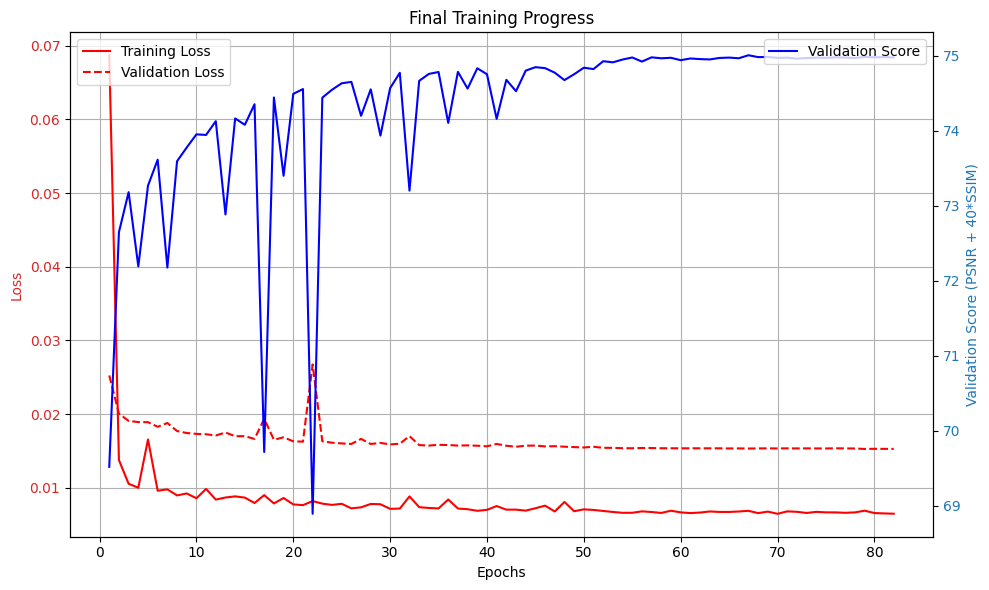


--- Preparing Stage 2: MPRNet ---

--- Starting Training for MPRNet ---


MPRNet Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Training:   0%|          | 0/384 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]


Early stopping triggered for MPRNet after 15 epochs with no improvement.

Training finished for MPRNet. Loading best model state with score: 75.00


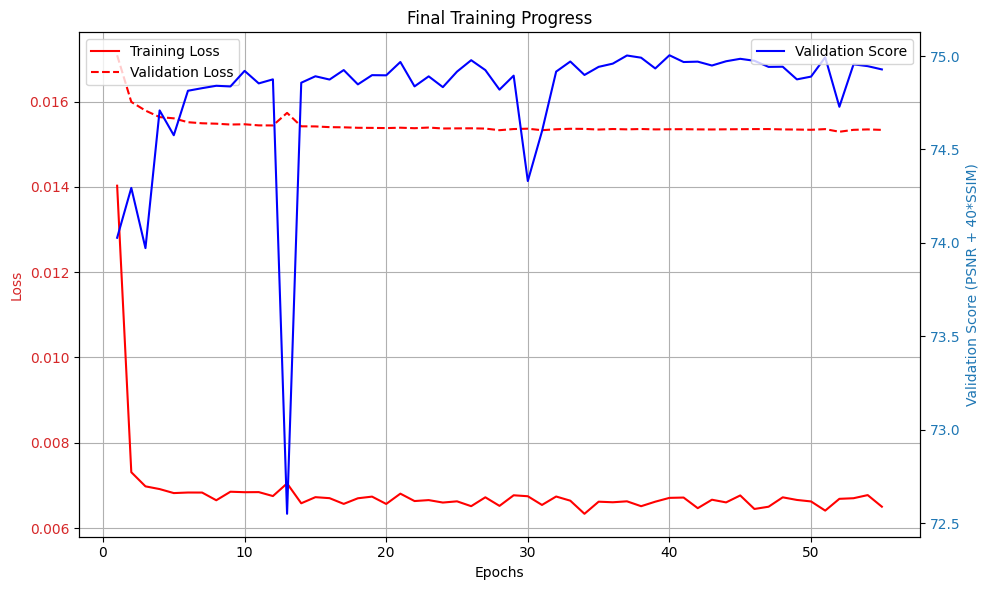


SRNet Best Validation Score: 75.01
MPRNet Best Validation Score: 75.00


In [9]:
# --- General Hyperparameters ---
batch_size = 5 # Adjust based on GPU memory, especially for MPRNet
num_epoch = 200
patience_early_stopping = 15
save_dir = 'saved_models'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda')) # Enable scaler only for CUDA

# --- Stage 1: SRNet Configuration ---
srnet_lr = 1e-4
srnet_scheduler_patience = 5
srnet_scheduler_factor = 0.1
srnet_loss_alpha = 0.5
srnet_loss_beta = 0.5
skip_srnet_training = False # <<<<<<<<<<<<< SET TO True TO LOAD PRE-TRAINED SRNET <<<<<<<<<<<<<
srnet_pretrained_path = 'saved_models/best_model_score_74p98_time_20250422_160331.pth' # <<<<<<<<<<<<< PATH TO YOUR SAVED SRNet MODEL <<<<<<<<<<<<<

# --- Stage 2: MPRNet Configuration ---
mprnet_lr = 1e-5 # Often requires smaller LR than the first stage
mprnet_scheduler_patience = 7
mprnet_scheduler_factor = 0.5
mprnet_loss_alpha = 0.5
mprnet_loss_beta = 0.5
# Weights for MPRNet intermediate losses (Stage1 SAM, Stage2 SAM, Final Output)
mprnet_stage_weights = [0.2, 0.3, 0.5] # Example weights, adjust as needed
mprnet_n_feat = 32 # MPRNet can be memory intensive, adjust features if needed
mprnet_scale_orsnetfeats = 16 # Feature scaling factor in ORSNet stage
mprnet_scale_unetfeats = 16 # Feature scaling factor in U-Net stages
mprnet_num_cab_in_orb = 8   # Number of CABs per ORB in Stage 3 ORSNet
mprnet_kernel_size = 3
mprnet_reduction = 4
mprnet_bias = False # Bias parameter for convolutions

# --- Setup DataLoaders ---
# Define transform (ensure it's defined before datasets)
transform = transforms.Compose([transforms.ToTensor()])
# Create the dataset for images
train_dataset = TIFFDataset('data/train/high-res', 'data/train/low-res', transform=transform, augment=True, dataset_name="Training Set")
val_dataset = TIFFDataset('data/val/high-res', 'data/val/low-res', transform=transform, augment=False, dataset_name="Validation Set")
train_dataset.verify_clamped_values()
val_dataset.verify_clamped_values()
# Create DataLoaders
train_loader = create_loader(train_dataset, batch_size, shuffle_data=True)
val_loader = create_loader(val_dataset, batch_size, shuffle_data=False)
print(f"Training data: {len(train_dataset)} samples")
print(f"Validation data: {len(val_dataset)} samples")


# --- Stage 1: SRNet Training (or Loading) ---
print("\n--- Preparing Stage 1: SRNet ---")
srnet_model = SRNet().to(device)
best_srnet_score = -1
best_srnet_state = None

if skip_srnet_training:
    if os.path.exists(srnet_pretrained_path):
        print(f"Loading pre-trained SRNet from: {srnet_pretrained_path}")
        srnet_model.load_state_dict(torch.load(srnet_pretrained_path, map_location=device))
        # Optional: Evaluate the loaded model
        print("Evaluating loaded SRNet model...")
        temp_criterion = CombinedLoss(alpha=srnet_loss_alpha, beta=srnet_loss_beta, device=device).to(device)
        psnr_metric_eval = PeakSignalNoiseRatio().to(device)
        ssim_metric_eval = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
        _, best_srnet_score, _, _ = validate_one_epoch(srnet_model, val_loader, temp_criterion, psnr_metric_eval, ssim_metric_eval, device)
        print(f"Loaded SRNet validation score: {best_srnet_score:.2f}")
        best_srnet_state = srnet_model.state_dict() # Keep the state
    else:
        print(f"Error: Pre-trained SRNet model not found at {srnet_pretrained_path}. Exiting.")
        exit()
else:
    print("Configuring SRNet for training...")
    srnet_opt = optim.Adam(srnet_model.parameters(), lr=srnet_lr)
    srnet_criterion = CombinedLoss(alpha=srnet_loss_alpha, beta=srnet_loss_beta, device=device).to(device)
    srnet_scheduler = ReduceLROnPlateau(srnet_opt, mode='max', factor=srnet_scheduler_factor, patience=srnet_scheduler_patience)

    best_srnet_score, best_srnet_state = train_model(
        model_name="SRNet",
        model=srnet_model,
        opt=srnet_opt,
        criterion=srnet_criterion,
        scheduler=srnet_scheduler,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epoch=num_epoch,
        patience=patience_early_stopping,
        device=device,
        save_dir=save_dir,
        scaler=scaler
    )
    if best_srnet_state:
        srnet_model.load_state_dict(best_srnet_state) # Ensure model has best state
    else:
         print("SRNet training finished without finding a best state. MPRNet training may be affected.")
         # Decide how to proceed - exit or use the last state? For now, we proceed.


# --- Stage 2: MPRNet Training ---
print("\n--- Preparing Stage 2: MPRNet ---")
# Ensure SRNet is in evaluation mode and gradients are off
srnet_model.eval()
for param in srnet_model.parameters():
    param.requires_grad = False

# --- Initialize MPRNet with updated parameters ---
mprnet_model = MPRNet(in_c=1, out_c=1,
                      n_feat=mprnet_n_feat,
                      scale_unetfeats=mprnet_scale_unetfeats,
                      scale_orsnetfeats=mprnet_scale_orsnetfeats,
                      num_cab_in_orb=mprnet_num_cab_in_orb,
                      kernel_size=mprnet_kernel_size,
                      reduction=mprnet_reduction,
                      bias=mprnet_bias).to(device)

# --- Setup Optimizer, Criterion, Scheduler for MPRNet ---
mprnet_opt = optim.Adam(mprnet_model.parameters(), lr=mprnet_lr)
mprnet_criterion = CombinedLoss(alpha=mprnet_loss_alpha, beta=mprnet_loss_beta, device=device, stage_weights=mprnet_stage_weights).to(device)
mprnet_scheduler = ReduceLROnPlateau(mprnet_opt, mode='max', factor=mprnet_scheduler_factor, patience=mprnet_scheduler_patience)

best_mprnet_score, best_mprnet_state = train_model(
    model_name="MPRNet",
    model=mprnet_model,
    opt=mprnet_opt,
    criterion=mprnet_criterion,
    scheduler=mprnet_scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epoch=num_epoch, # Can use the same or different number of epochs
    patience=patience_early_stopping, # Can use the same or different patience
    device=device,
    save_dir=save_dir,
    scaler=scaler,
    srnet_model=srnet_model # Pass the frozen SRNet model
)

if best_mprnet_state:
    mprnet_model.load_state_dict(best_mprnet_state) # Ensure model has best state
else:
    print("MPRNet training finished without finding a best state.")

print(f"\nSRNet Best Validation Score: {best_srnet_score:.2f}")
print(f"MPRNet Best Validation Score: {best_mprnet_score:.2f}")

___
### Apply it one of the validation image

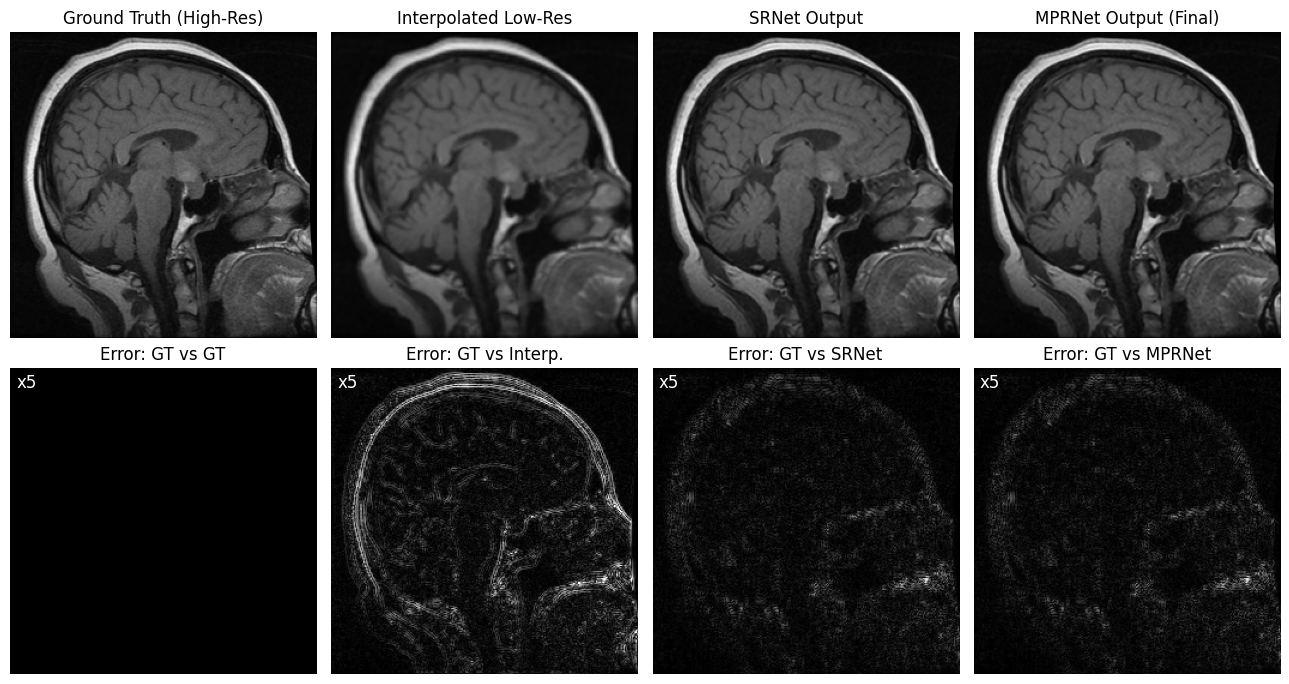

In [10]:
# Load one (low-res, high-res) image pair from validation dataset
val_low_res, val_high_res = val_dataset[1]  # Input (128x128), Ground truth (256x256)
val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

# Keep the interpolated version ONLY for visualization comparison
val_low_res_interpolated = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False).squeeze(0)

# Apply the trained models sequentially
with torch.no_grad():
    with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
        val_sr_res = srnet_model(val_low_res.unsqueeze(0))
        val_mpr_res_full = mprnet_model(val_sr_res)
        # Use final output from MPRNet if it returns a list
        val_mpr_res = val_mpr_res_full[0] if isinstance(val_mpr_res_full, (list, tuple)) else val_mpr_res_full

val_sr_res = val_sr_res.detach().squeeze(0)
val_mpr_res = val_mpr_res.detach().squeeze(0)


# Convert tensors to numpy for visualization
val_low_res_np = val_low_res_interpolated.squeeze().cpu().numpy()
val_high_res_np = val_high_res.squeeze().cpu().numpy()
val_sr_res_np = val_sr_res.squeeze().cpu().numpy()
val_mpr_res_np = val_mpr_res.squeeze().cpu().numpy()


# Plot example images and error maps
fig, ax = plt.subplots(2, 4, figsize=(13, 7)) # Increased columns for MPRNet

# Plot images
ax[0, 0].imshow(val_high_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('Ground Truth (High-Res)')
ax[0, 0].axis('off')

ax[0, 1].imshow(val_low_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('Interpolated Low-Res')
ax[0, 1].axis('off')

ax[0, 2].imshow(val_sr_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('SRNet Output')
ax[0, 2].axis('off')

ax[0, 3].imshow(val_mpr_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 3].set_title('MPRNet Output (Final)')
ax[0, 3].axis('off')


# Error maps (multiplied by 5 for visibility)
error_scale = 5
ax[1, 0].imshow(error_scale * np.abs(val_high_res_np - val_high_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 0].set_title('Error: GT vs GT')
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, f'x{error_scale}', transform=ax[1, 0].transAxes, fontsize=12, va='top', ha='left', color='white')

ax[1, 1].imshow(error_scale * np.abs(val_high_res_np - val_low_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 1].set_title('Error: GT vs Interp.')
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, f'x{error_scale}', transform=ax[1, 1].transAxes, fontsize=12, va='top', ha='left', color='white')

ax[1, 2].imshow(error_scale * np.abs(val_high_res_np - val_sr_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 2].set_title('Error: GT vs SRNet')
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, f'x{error_scale}', transform=ax[1, 2].transAxes, fontsize=12, va='top', ha='left', color='white')

ax[1, 3].imshow(error_scale * np.abs(val_high_res_np - val_mpr_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 3].set_title('Error: GT vs MPRNet')
ax[1, 3].axis('off')
ax[1, 3].text(0.02, 0.98, f'x{error_scale}', transform=ax[1, 3].transAxes, fontsize=12, va='top', ha='left', color='white')

plt.tight_layout()
plt.show()

### Compute PSNR and SSIM over the entire validation dataset

In [11]:
def evaluate_final_models(srnet_model, mprnet_model, data_loader, device):
    """Computes metrics for SRNet and MPRNet outputs."""
    srnet_model.eval()
    mprnet_model.eval()
    psnr_metric = PeakSignalNoiseRatio().to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    total_psnr_sr = 0.0
    total_ssim_sr = 0.0
    total_psnr_mpr = 0.0
    total_ssim_mpr = 0.0
    total_psnr_interp = 0.0
    total_ssim_interp = 0.0
    num_samples = 0

    with torch.no_grad():
        eval_pbar = tqdm(data_loader, desc="Final Evaluation")
        for x_batch, y_batch in eval_pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device) # x is 128x128
            batch_size_actual = x_batch.size(0)
            num_samples += batch_size_actual

            # Interpolated Baseline
            x_batch_interpolated = torch.nn.functional.interpolate(x_batch, scale_factor=2, mode='bicubic', align_corners=False)

            # --- Mixed Precision Evaluation ---
            with torch.amp.autocast(device_type=device.type, dtype=torch.float16, enabled=True):
                # SRNet Output
                sr_output = srnet_model(x_batch) # 256x256

                # MPRNet Output
                mpr_output_full = mprnet_model(sr_output) # MPRNet takes SRNet output
                # Use final output from MPRNet if it returns a list
                mpr_output = mpr_output_full[0] if isinstance(mpr_output_full, (list, tuple)) else mpr_output_full


            # --- Calculate Metrics ---
            # Interpolated
            psnr_interp = psnr_metric(x_batch_interpolated, y_batch)
            ssim_interp = ssim_metric(x_batch_interpolated, y_batch)
            total_psnr_interp += psnr_interp.item() * batch_size_actual
            total_ssim_interp += ssim_interp.item() * batch_size_actual

            # SRNet
            psnr_sr = psnr_metric(sr_output, y_batch)
            ssim_sr = ssim_metric(sr_output, y_batch)
            total_psnr_sr += psnr_sr.item() * batch_size_actual
            total_ssim_sr += ssim_sr.item() * batch_size_actual

            # MPRNet
            psnr_mpr = psnr_metric(mpr_output, y_batch)
            ssim_mpr = ssim_metric(mpr_output, y_batch)
            total_psnr_mpr += psnr_mpr.item() * batch_size_actual
            total_ssim_mpr += ssim_mpr.item() * batch_size_actual

            eval_pbar.set_postfix({'SR Score': f'{psnr_sr.item() + 40*ssim_sr.item():.2f}',
                                   'MPR Score': f'{psnr_mpr.item() + 40*ssim_mpr.item():.2f}'})


    # Calculate averages
    avg_psnr_interp = total_psnr_interp / num_samples
    avg_ssim_interp = total_ssim_interp / num_samples
    avg_psnr_sr = total_psnr_sr / num_samples
    avg_ssim_sr = total_ssim_sr / num_samples
    avg_psnr_mpr = total_psnr_mpr / num_samples
    avg_ssim_mpr = total_ssim_mpr / num_samples

    # Calculate scores
    avg_score_interp = avg_psnr_interp + (40 * avg_ssim_interp)
    avg_score_sr = avg_psnr_sr + (40 * avg_ssim_sr)
    avg_score_mpr = avg_psnr_mpr + (40 * avg_ssim_mpr)

    # Print results
    print("\n--- Final Evaluation Results ---")
    print(f'Metric                | Interpolated |   SRNet   |  MPRNet  ')
    print(f'----------------------|--------------|-----------|----------')
    print(f'Average PSNR (dB)     | {avg_psnr_interp:12.2f} | {avg_psnr_sr:9.2f} | {avg_psnr_mpr:8.2f}')
    print(f'Average SSIM          | {avg_ssim_interp:12.4f} | {avg_ssim_sr:9.4f} | {avg_ssim_mpr:8.4f}')
    print(f'Average Score         | {avg_score_interp:12.2f} | {avg_score_sr:9.2f} | {avg_score_mpr:8.2f}')

    return avg_score_sr, avg_score_mpr, avg_score_interp

# --- Call the Final Evaluation Function ---
# Ensure both models have their best states loaded before calling this
# (This should be handled by the end of the training section)
final_sr_score, final_mpr_score, final_interp_score = evaluate_final_models(
    srnet_model, mprnet_model, val_loader, device
)

Final Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]


--- Final Evaluation Results ---
Metric                | Interpolated |   SRNet   |  MPRNet  
----------------------|--------------|-----------|----------
Average PSNR (dB)     |        30.96 |     36.42 |    36.43
Average SSIM          |       0.9074 |    0.9646 |   0.9645
Average Score         |        67.26 |     75.01 |    75.00
